In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False
import os
print(os.listdir())

['Raj_Kallakuri_v1.ipynb', 'stage_2_test_images', 'Pneumonia detection challenge_Priya.ipynb', 'rsna-pneumonia-detection-eda.ipynb', 'stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_train_images', 'starter-pneumonia-detection-7645fe37-e.ipynb', 'exploratory-data-analysis.ipynb', 'GCP Credits Request Link - RSNA.txt', 'stage_2_train_labels.csv', '.ipynb_checkpoints', 'lung-opacity-overview.ipynb']


In [2]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv') 

In [3]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [4]:
class_info_df.sample(10)

patientId                         class
19128  b2753475-d0b2-4dde-8a7b-311e1db27397                  Lung Opacity
1754   18792f05-1f16-4343-884c-c33420e6b104                  Lung Opacity
27337  f2cdb6cd-1196-40de-baa9-5e23a9cf3370                        Normal
17574  a7a7a9f6-3d31-4626-8777-fa2003adb972                        Normal
29655  201fe232-cebb-4e8d-ab9a-f41f03bd676a                  Lung Opacity
20190  b9ab20d2-6e02-4745-b9c8-fe4db09004a5  No Lung Opacity / Not Normal
5022   436db323-0490-40eb-8b48-b2768195768f  No Lung Opacity / Not Normal
24341  dab65a9f-4277-44e2-8d07-ad2365849224  No Lung Opacity / Not Normal
23357  d25064e1-6b63-4253-ab14-10137214e47e  No Lung Opacity / Not Normal
3575   393479fe-4d10-4f40-ba01-6a4710632626  No Lung Opacity / Not Normal

In [5]:
train_labels_df.sample(10)

patientId      x      y  width  height  \
8850   62df23c0-1089-4281-9688-036e92189ba1    NaN    NaN    NaN     NaN   
2325   31460e18-fc20-4b1d-9c80-c9c266f9f9ba    NaN    NaN    NaN     NaN   
22603  cc2b8292-35f6-484b-99b2-4afe247b1675    NaN    NaN    NaN     NaN   
27505  f43d1494-2924-4e7e-ba1f-12bbe10219ad    NaN    NaN    NaN     NaN   
3606   396d1f4b-6370-48ba-a3ab-3a891085934c    NaN    NaN    NaN     NaN   
21216  c060c23e-dff3-4cbd-b823-b8e70b80b2b4  262.0  532.0  154.0   163.0   
14607  9010bc62-c2c8-465a-8298-4d1b3c7f527d    NaN    NaN    NaN     NaN   
5687   48e264dc-d8d4-4e82-aa62-ed0174d321ea  537.0  396.0  133.0   253.0   
14797  9195deb9-f780-40e0-b253-8fcf34ef2b76    NaN    NaN    NaN     NaN   
13958  8b216d4c-23b0-427e-aa94-d516d4ae9698  196.0  358.0  253.0   287.0   

       Target  
8850        0  
2325        0  
22603       0  
27505       0  
3606        0  
21216       1  
14607       0  
5687        1  
14797       0  
13958       1

In **class detailed info** dataset are given the detailed information about the type of positive or negative class associated with a certain patient.  

In **train labels** dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.

# Let's check missing information in the two datasets. 

In [6]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels_df)

height         width             y             x  Target  \
Total    20672.000000  20672.000000  20672.000000  20672.000000     0.0   
Percent     68.389188     68.389188     68.389188     68.389188     0.0   

         patientId  
Total          0.0  
Percent        0.0

In [7]:
missing_data(class_info_df)

class  patientId
Total      0.0        0.0
Percent    0.0        0.0

The percent missing for x,y, height and width in train labels represents the percent of the target **0** (not **Lung opacity**).

Let's check the class distribution from class detailed info.

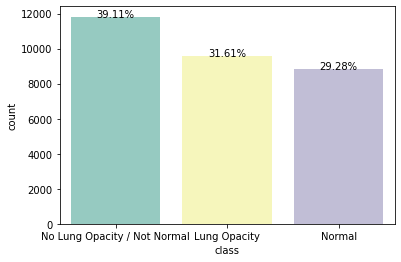

In [8]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [9]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(class_info_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


**No Lung Opacity / Not Normal** and **Normal** have together the same percent (**69.077%**) as the percent of missing values for target window in class details information.   

In the train set, the percent of data with value for **Target = 1** is therefore **30.92%**.   





## Merge train and class detail info data

Let's merge now the two datasets, using Patient ID as the merge criteria.

In [10]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [11]:
train_class_df.sample(5)

patientId      x      y  width  height  \
32839  eb82b8a8-8710-4364-bb9b-8dcfe0edf813    NaN    NaN    NaN     NaN   
32616  e9e58cf9-f301-4fe9-a5d5-ff12f7981612  203.0  343.0  170.0   308.0   
3616   32e9a5df-2282-4204-8355-030f26816f33    NaN    NaN    NaN     NaN   
29583  d2aaaa5c-9238-4cde-90fd-b6a548c85b00    NaN    NaN    NaN     NaN   
1257   0b6c6a3e-4eda-4886-9182-e0b686fd9e53    NaN    NaN    NaN     NaN   

       Target                         class  
32839       0  No Lung Opacity / Not Normal  
32616       1                  Lung Opacity  
3616        0  No Lung Opacity / Not Normal  
29583       0                        Normal  
1257        0                        Normal

### Target and class  

Let's plot the number of examinations for each class detected, grouped by Target value.

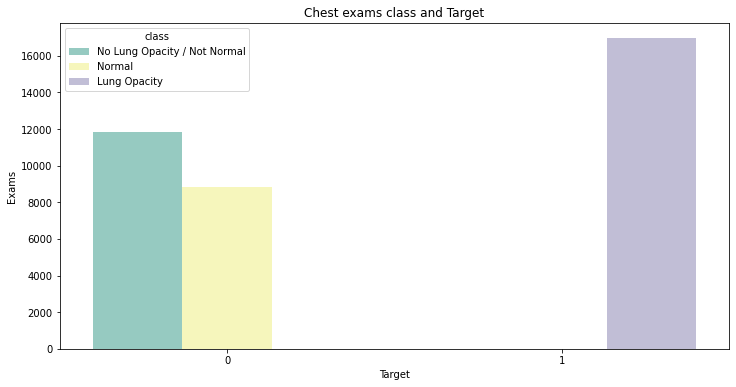

In [12]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

All chest examinations with`Target` = **1** (pathology detected) associated with `class`:  **Lung Opacity**.    

The chest examinations with `Target` = **0** (no pathology detected) are either of `class`: **Normal** or `class`: **No Lung Opacity / Not Normal**.

### Detected Lung Opacity window   

For the class **Lung Opacity**, corresponding to values of **Target = 1**, we plot the density of **x**, **y**, **width** and **height**.



<Figure size 432x288 with 0 Axes>

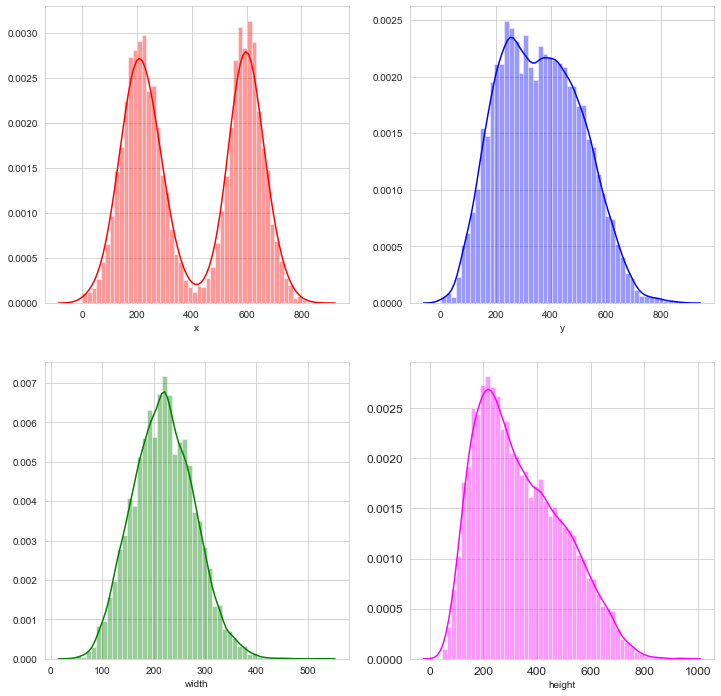

In [13]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

We can plot also the center of the rectangles points in the plane x0y.   The centers of the rectangles are the points $$x_c = x + \frac{width}{2}$$ and $$y_c = y + \frac{height}{2}$$.

We will show a sample of center points superposed with the corresponding sample of the rectangles.
The rectangles are created using the method described in Kevin's Kernel

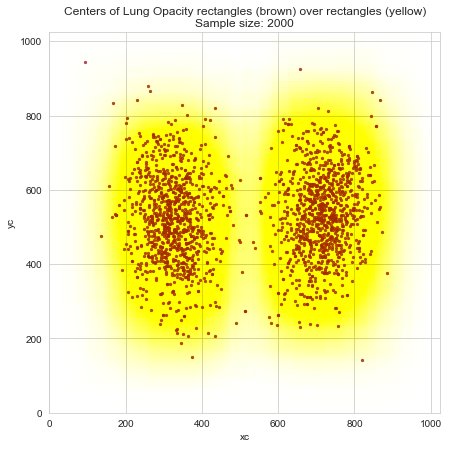

In [14]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

We follow with the exploration of the DICOM data.



Let's read now the DICOM data in the train set. The image path is as following:

In [15]:
image_sample_path = os.listdir('stage_2_train_images')[:5]
print(image_sample_path)

['7be6b4de-afe9-43c0-a581-0f49608c8976.dcm', '2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm', 'd8e66874-305e-4c80-9b75-5e764eb718ff.dcm', '22f2d3ec-f7ea-4778-850d-bb111590202f.dcm', 'cdaa07d4-4234-4cd2-b9bf-abbf5aed1bb4.dcm']


The files names are the patients IDs.    
Let's check how many images are in the train and test folders.

In [16]:
image_train_path = os.listdir('stage_2_train_images')
image_test_path = os.listdir('stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000




Only a reduced number of images are present in the training set (**26684**), compared with the number of  images in the train_df data (**30227**).  

It might be that we do have duplicated entries in the train and class datasets. Let's check this.

### Check duplicates in train dataset

In [17]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())      

Unique patientId in  train_class_df:  26684


We confirmed that the number of *unique* **patientsId** are equal with the number of DICOM images in the train set.  

Let's see what entries are duplicated. We want to check how are these distributed accross classes and Target value.

In [18]:
tmp = train_class_df.groupby(['patientId','Target', 'class'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
df2.columns = ['Exams', 'Target','Class', 'Entries']
df2

Exams  Target                         Class  Entries
0      1       0  No Lung Opacity / Not Normal    11821
1      1       0                        Normal     8851
2      1       1                  Lung Opacity     2614
3      4       1                  Lung Opacity     3266
4      9       1                  Lung Opacity      119
5     16       1                  Lung Opacity       13

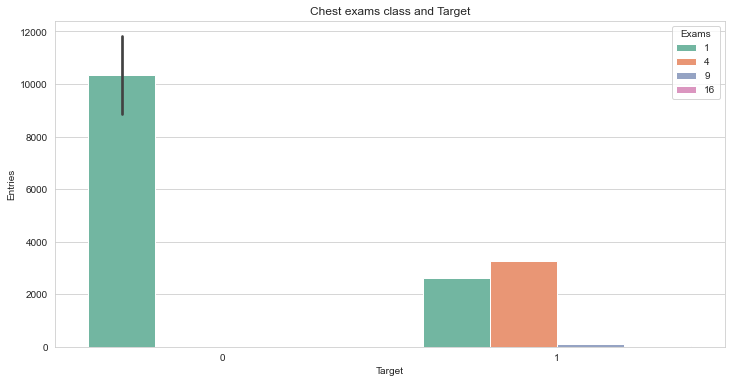

In [19]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
sns.barplot(ax=ax,x = 'Target', y='Entries', hue='Exams',data=df2, palette='Set2')
plt.title("Chest exams class and Target")
plt.show()

Let's now extract one image and process the DICOM information. 

### DICOM meta data

In [20]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("stage_2_train_images",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

We can observe that we do have available some useful information in the DICOM metadata with predictive value, for example:
Patient sex;
Patient age;
Modality;
Body part examined;
View position;
Rows & Columns;
Pixel Spacing.

Let's sample few images having the **Target = 1**.

### Plot DICOM images with Target = 1

In [21]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

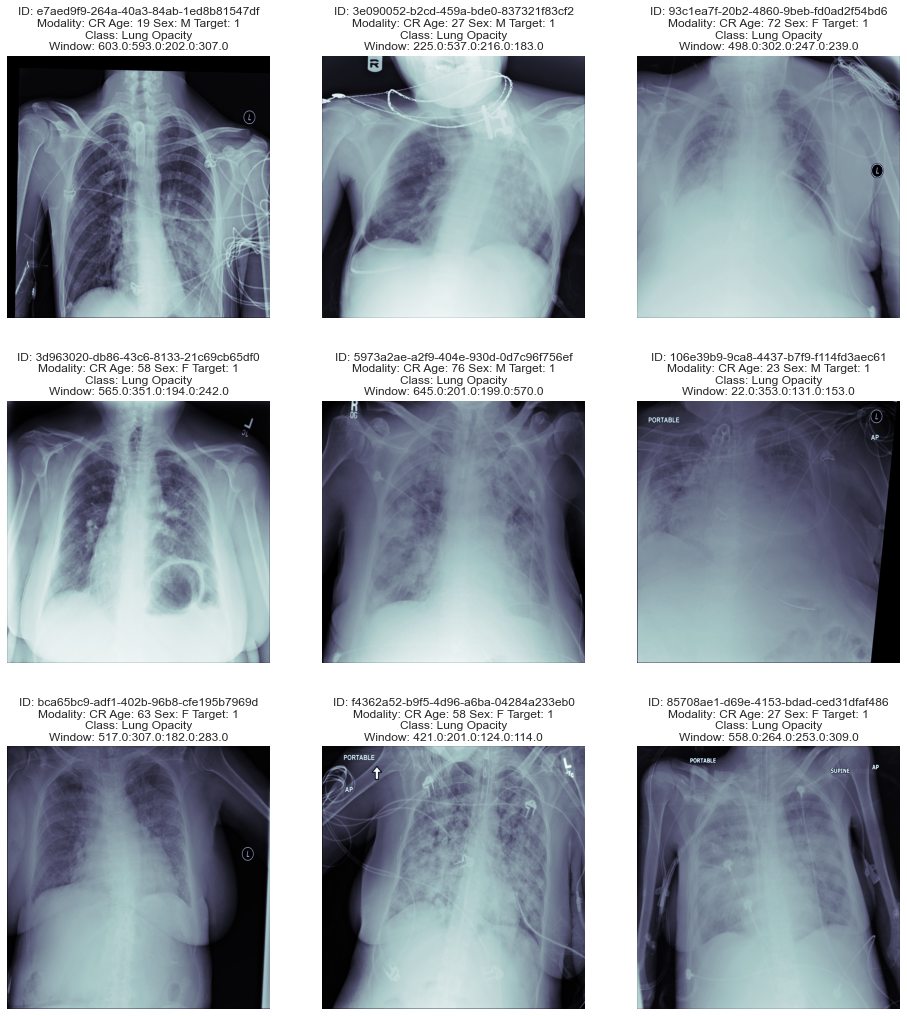

In [22]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

We would like to represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with **Target = 1** and gather all coordinates of the windows showing a **Lung Opacity** on the same image.  The simples method is show in <a href='#5'>[1]</a> and we will adapt our rendering from this method.

In [23]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join("stage_2_train_images",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

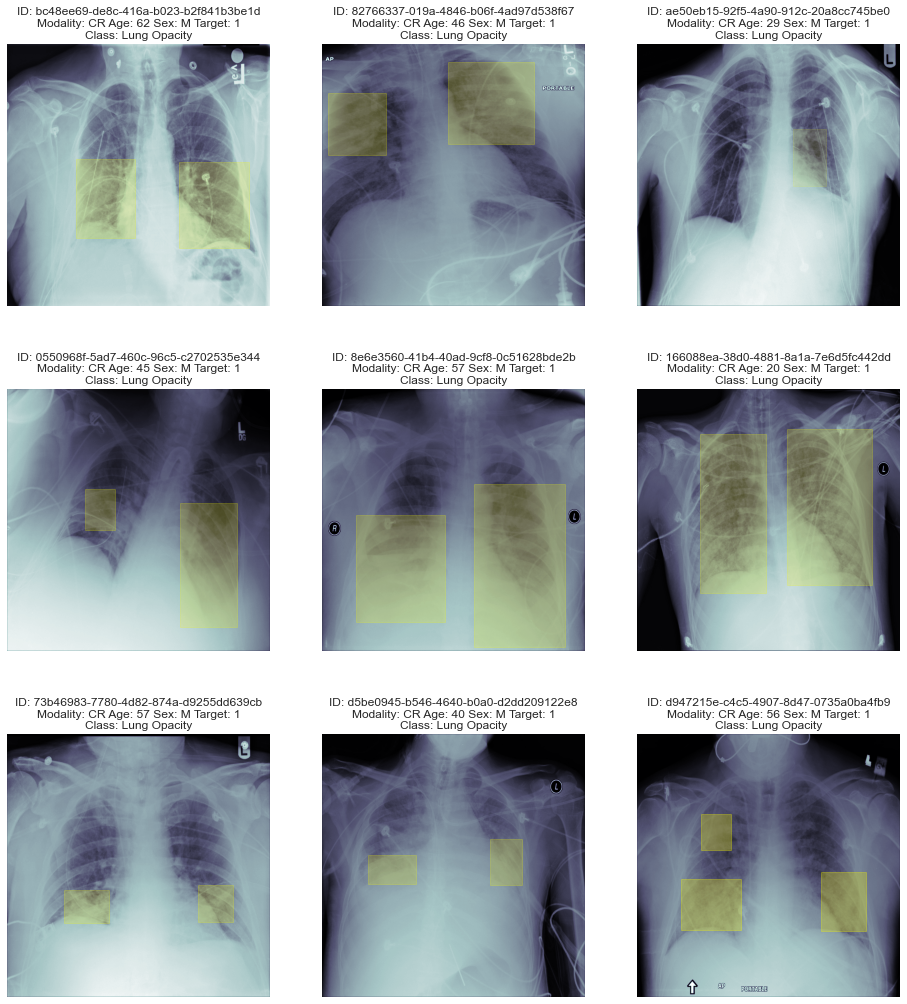

In [24]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

For some of the images with **Target=1**, we might see multiple areas (boxes/rectangles) with **Lung Opacity**.

Let's sample few images having the **Target = 0**.   

### Plot DICOM images with Target = 0



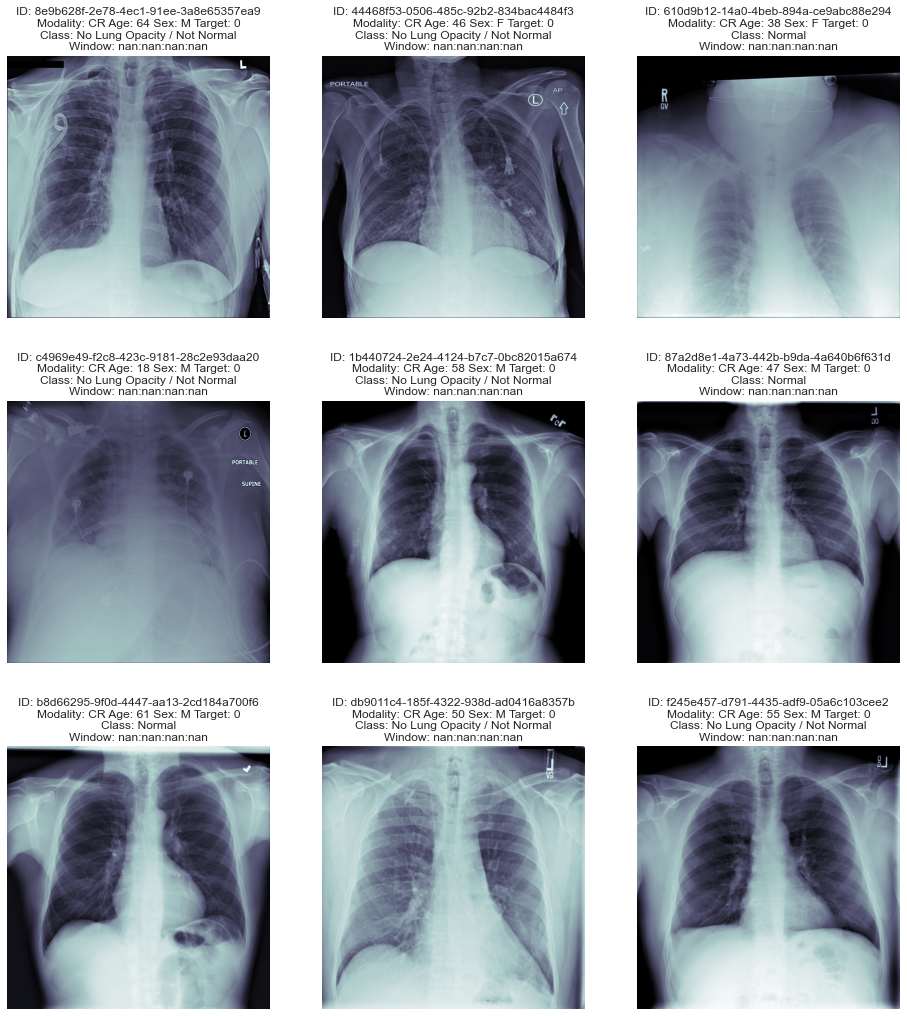

In [25]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

# Add meta information from DICOM data
Train data
We will parse the DICOM meta information and add it to the train dataset. We will do the same with the test data.

In [26]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

In [27]:
process_dicom_data(train_class_df,'stage_2_train_images')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


### Test data

We will create as well a test dataset with similar information.

In [28]:
test_class_df = pd.read_csv('stage_2_sample_submission.csv')

In [29]:
test_class_df = test_class_df.drop('PredictionString',1)
process_dicom_data(test_class_df,'stage_2_test_images')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Modality
Let's check how many modalities are used. Both train and test set are checked

In [30]:
print("Modalities: train:",train_class_df['Modality'].unique(), "test:", test_class_df['Modality'].unique())

Modalities: train: ['CR'] test: ['CR']


# Body Part Examined
Let's check if other body parts than 'CHEST' appears in the data.

In [31]:
print("Body Part Examined: train:",train_class_df['BodyPartExamined'].unique(), "test:", test_class_df['BodyPartExamined'].unique())

Body Part Examined: train: ['CHEST'] test: ['CHEST']


View Position is a radiographic view associated with the Patient Position. Let's check the View Positions distribution for the both datasets.

In [32]:
print("View Position: train:",train_class_df['ViewPosition'].unique(), "test:", test_class_df['ViewPosition'].unique())

View Position: train: ['PA' 'AP'] test: ['PA' 'AP']


### Train dataset  

Let's get into more details for the train dataset. First, let's check the distribution of PA and AP.

In [33]:
get_feature_distribution(train_class_df,'ViewPosition')

Feature: ViewPosition
AP                            :   21817 or 57.97%
PA                            :   15812 or 42.02%


In [34]:
def plot_window(data,color_point, color_window,text):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plt.title("Centers of Lung Opacity rectangles over rectangles\n{}".format(text))
    data.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color=color_point)
    for i, crt_sample in data.iterrows():
        ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
            width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color=color_window))
    plt.show()

We sample a subset of the train data with **Target = 1**. We calculate as well the center of the windows with **Lung Opacity**.   We then select from this sample the data with the two view position, to plot the window distribution separatelly.

In [35]:
target1 = train_class_df[train_class_df['Target']==1]

target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2

target_ap = target_sample[target_sample['ViewPosition']=='AP']
target_pa = target_sample[target_sample['ViewPosition']=='PA']



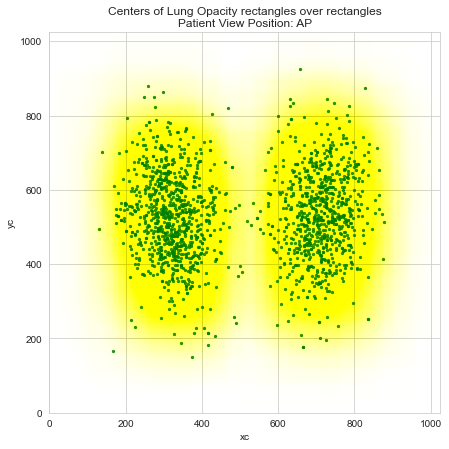

In [36]:
plot_window(target_ap,'green', 'yellow', 'Patient View Position: AP')

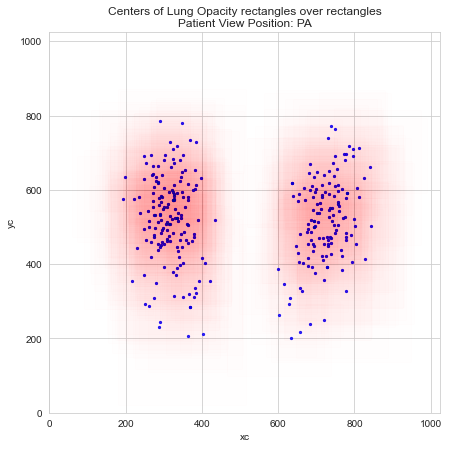

In [37]:
plot_window(target_pa,'blue', 'red', 'Patient View Position: PA')

Test dataset
Let's check the distribution of AP and PA positions for the test set

In [38]:
get_feature_distribution(test_class_df,'ViewPosition')

Feature: ViewPosition
PA                            :   1618 or 53.93%
AP                            :   1382 or 46.06%


In [39]:
print("Conversion Type: train:",train_class_df['ConversionType'].unique(), "test:", test_class_df['ConversionType'].unique())

Conversion Type: train: ['WSD'] test: ['WSD']


In [40]:
print("Rows: train:",train_class_df['Rows'].unique(), "test:", test_class_df['Rows'].unique())
print("Columns: train:",train_class_df['Columns'].unique(), "test:", test_class_df['Columns'].unique())

Rows: train: [1024] test: [1024]
Columns: train: [1024] test: [1024]


Patient Age
Let's examine now the data for the Patient Age for the train set.
Train dataset

In [41]:
tmp = train_class_df.groupby(['Target', 'PatientAge'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientAge']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

In [42]:
tmp = train_class_df.groupby(['class', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientAge']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

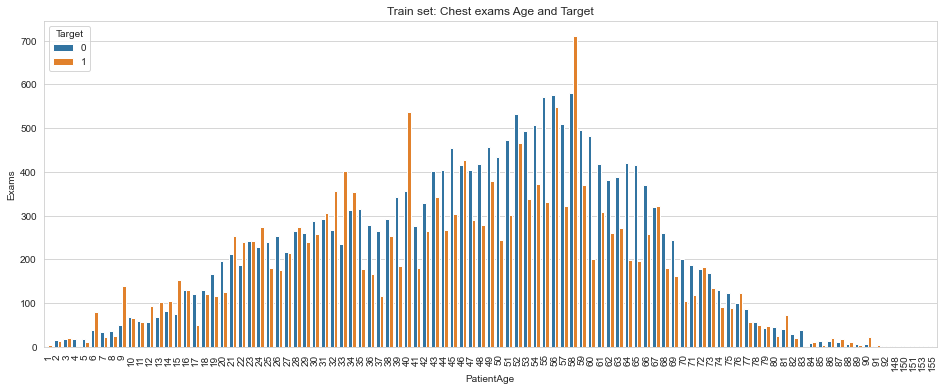

In [43]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='Target',data=df2)
plt.title("Train set: Chest exams Age and Target")
plt.xticks(rotation=90)
plt.show()

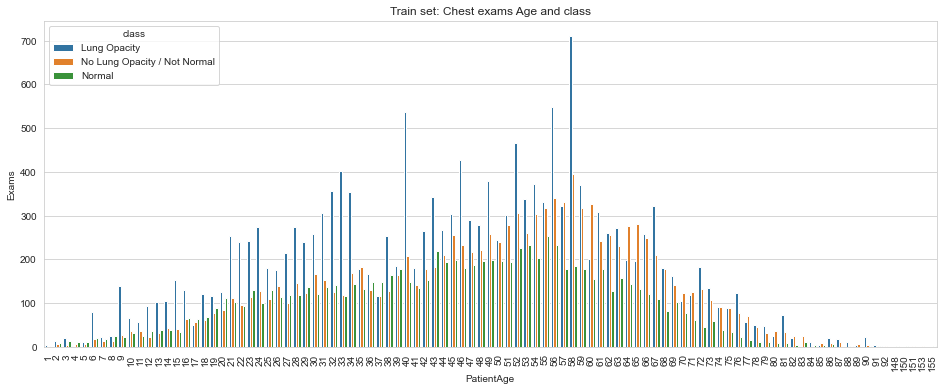

In [44]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y='Exams', hue='class',data=df3)
plt.title("Train set: Chest exams Age and class")
plt.xticks(rotation=90)
plt.show()

Note: most probably, the values of age 148 to 155 are mistakes.
Let's group the ages in 5 groups (0-19, 20-34, 35-49, 50-64 and 65+).

In [45]:
target_age1 = target_sample[target_sample['PatientAge'] < 20]
target_age2 = target_sample[(target_sample['PatientAge'] >=20) & (target_sample['PatientAge'] < 35)]
target_age3 = target_sample[(target_sample['PatientAge'] >=35) & (target_sample['PatientAge'] < 50)]
target_age4 = target_sample[(target_sample['PatientAge'] >=50) & (target_sample['PatientAge'] < 65)]
target_age5 = target_sample[target_sample['PatientAge'] >= 65]

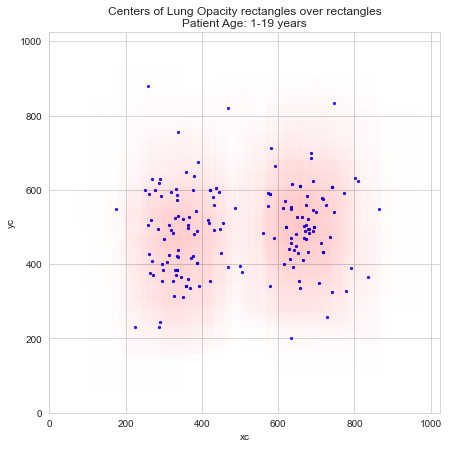

In [46]:
plot_window(target_age1,'blue', 'red', 'Patient Age: 1-19 years')

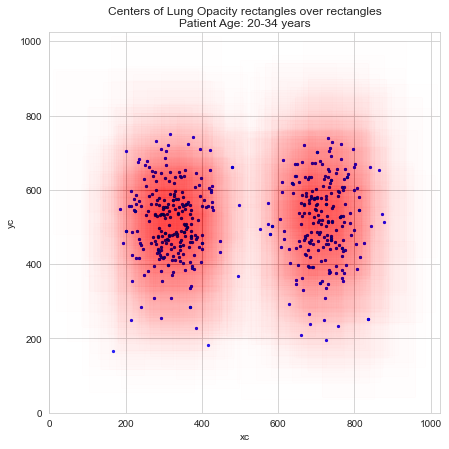

In [47]:
plot_window(target_age2,'blue', 'red', 'Patient Age: 20-34 years')

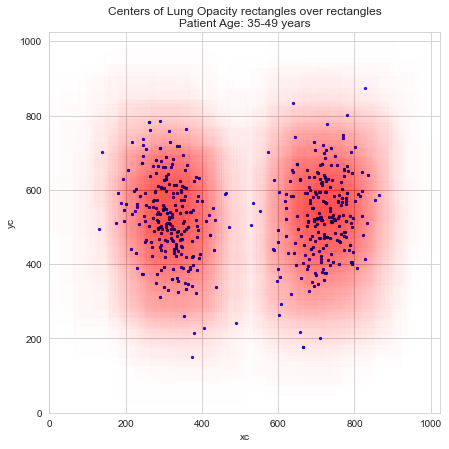

In [48]:
plot_window(target_age3,'blue', 'red', 'Patient Age: 35-49 years')

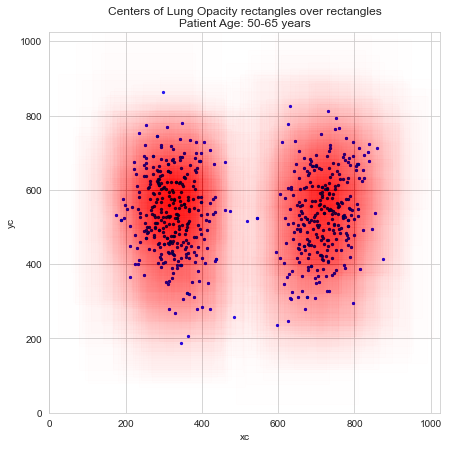

In [49]:
plot_window(target_age4,'blue', 'red', 'Patient Age: 50-65 years')

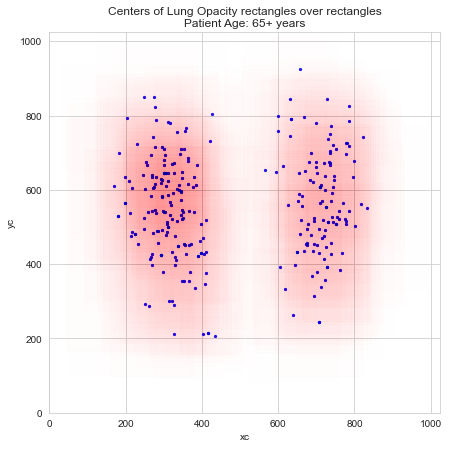

In [50]:
plot_window(target_age5,'blue', 'red', 'Patient Age: 65+ years')

Let's check also the distribution of patient age for the test data set.

### Test dataset

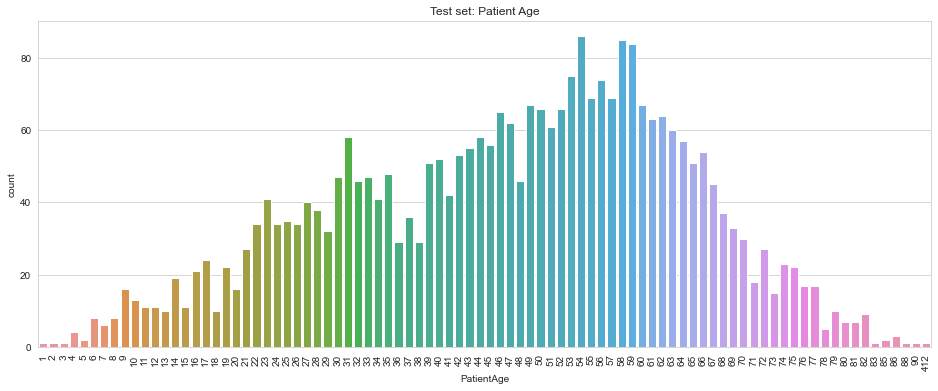

In [51]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(test_class_df['PatientAge'], ax=ax)
plt.title("Test set: Patient Age")
plt.xticks(rotation=90)
plt.show()

# Patient Sex
Let's examine now the data for the Patient Sex.
Train dataset
We represent the number of Exams for each Patient Sex, grouped by value of Target.

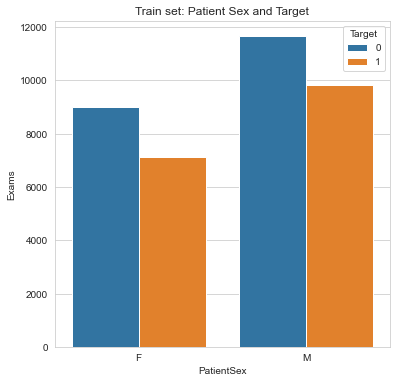

In [52]:
tmp = train_class_df.groupby(['Target', 'PatientSex'])['patientId'].count()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df.groupby(['Exams','Target', 'PatientSex']).count()
df2 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, ax = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='Target',data=df2)
plt.title("Train set: Patient Sex and Target")
plt.show()

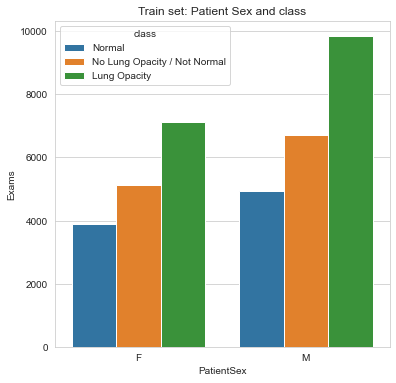

In [53]:
tmp = train_class_df.groupby(['class', 'PatientSex'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientSex']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, (ax) = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='class',data=df3)
plt.title("Train set: Patient Sex and class")
plt.show()

Let's plot as well the distribution of  window with Lung Opacity, separatelly for the female and male patients. We will reuse the sample with **Target = 1** for which we calculated also the center of the window.

In [54]:
target_female = target_sample[target_sample['PatientSex']=='F']
target_male = target_sample[target_sample['PatientSex']=='M']

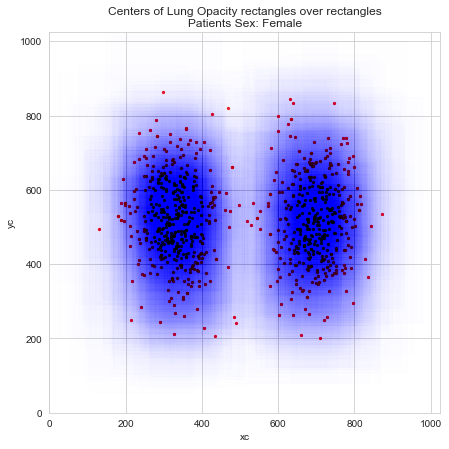

In [62]:
plot_window(target_female,"red", "blue","Patients Sex: Female")

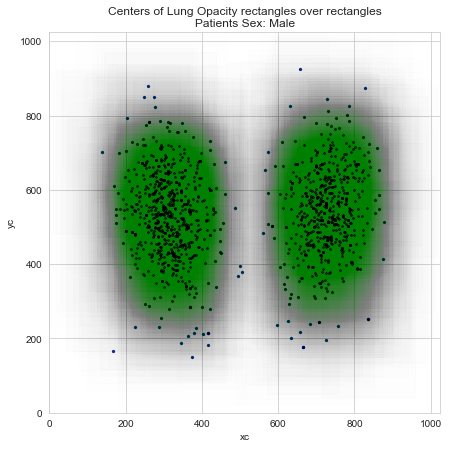

In [63]:
plot_window(target_male,"darkblue", "green", "Patients Sex: Male")

Test dataset



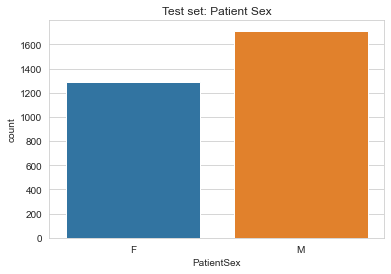

In [65]:
sns.countplot(test_class_df['PatientSex'])
plt.title("Test set: Patient Sex")
plt.show()

# Conclusions
After exploring the data, both the tabular and DICOM data, we were able to:

discover duplications in the tabular data;
explore the DICOM images;
extract meta information from the DICOM data;
add features to the tabular data from the meta information in DICOM data;
further analyze the distribution of the data with the newly added features from DICOM metadata;
All these findings are useful as preliminary work for building a model.

from __future__ import division
import torch as t
import numpy as np
import cupy as cp
from utils import array_tool as at
from models.model_utils.bbox_tools import loc2bbox
from models.model_utils.nms.non_maximum_suppression import non_maximum_suppression

from torch import nn
from data.dataset import preprocess
from torch.nn import functional as F
from utils.Config import opt


class FasterRCNN(nn.Module):
    """Base class for Faster R-CNN.
    This is a base class for Faster R-CNN links supporting object detection
    API [#]_. The following three stages constitute Faster R-CNN.
    1. **Feature extraction**: Images are taken and their \
        feature maps are calculated.
    2. **Region Proposal Networks**: Given the feature maps calculated in \
        the previous stage, produce set of RoIs around objects.
    3. **Localization and Classification Heads**: Using feature maps that \
        belong to the proposed RoIs, classify the categories of the objects \
        in the RoIs and improve localizations.
    Each stage is carried out by one of the callable
    :class:`torch.nn.Module` objects :obj:`feature`, :obj:`rpn` and :obj:`head`.
    There are two functions :meth:`predict` and :meth:`__call__` to conduct
    object detection.
    :meth:`predict` takes images and returns bounding boxes that are converted
    to image coordinates. This will be useful for a scenario when
    Faster R-CNN is treated as a black box function, for instance.
    :meth:`__call__` is provided for a scnerario when intermediate outputs
    are needed, for instance, for training and debugging.
    Links that support obejct detection API have method :meth:`predict` with
    the same interface. Please refer to :meth:`predict` for
    further details.
    .. [#] Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun. \
    Faster R-CNN: Towards Real-Time Object Detection with \
    Region Proposal Networks. NIPS 2015.
    Args:
        extractor (nn.Module): A module that takes a BCHW image
            array and returns feature maps.
        rpn (nn.Module): A module that has the same interface as
            :class:`model.region_proposal_network.RegionProposalNetwork`.
            Please refer to the documentation found there.
        head (nn.Module): A module that takes
            a BCHW variable, RoIs and batch indices for RoIs. This returns class
            dependent localization paramters and class scores.
        loc_normalize_mean (tuple of four floats): Mean values of
            localization estimates.
        loc_normalize_std (tupler of four floats): Standard deviation
            of localization estimates.
    """

    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)
    ):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.use_preset('evaluate')

    @property
    def n_class(self):
        # Total number of classes including the background.
        return self.head.n_class

    def forward(self, x, scale=1.):
        """Forward Faster R-CNN.
        Scaling paramter :obj:`scale` is used by RPN to determine the
        threshold to select small objects, which are going to be
        rejected irrespective of their confidence scores.
        Here are notations used.
        * :math:`N` is the number of batch size
        * :math:`R'` is the total number of RoIs produced across batches. \
            Given :math:`R_i` proposed RoIs from the :math:`i` th image, \
            :math:`R' = \\sum _{i=1} ^ N R_i`.
        * :math:`L` is the number of classes excluding the background.
        Classes are ordered by the background, the first class, ..., and
        the :math:`L` th class.
        Args:
            x (autograd.Variable): 4D image variable.
            scale (float): Amount of scaling applied to the raw image
                during preprocessing.
        Returns:
            Variable, Variable, array, array:
            Returns tuple of four values listed below.
            * **roi_cls_locs**: Offsets and scalings for the proposed RoIs. \
                Its shape is :math:`(R', (L + 1) \\times 4)`.
            * **roi_scores**: Class predictions for the proposed RoIs. \
                Its shape is :math:`(R', L + 1)`.
            * **rois**: RoIs proposed by RPN. Its shape is \
                :math:`(R', 4)`.
            * **roi_indices**: Batch indices of RoIs. Its shape is \
                :math:`(R',)`.
        """
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            self.rpn(h, img_size, scale)
        roi_cls_locs, roi_scores = self.head(
            img_size, h, rois, roi_indices)
        return roi_cls_locs, roi_scores, rois, roi_indices

    def use_preset(self, preset):
        """Use the given preset during prediction.
        This method changes values of :obj:`self.nms_thresh` and
        :obj:`self.score_thresh`. These values are a threshold value
        used for non maximum suppression and a threshold value
        to discard low confidence proposals in :meth:`predict`,
        respectively.
        If the attributes need to be changed to something
        other than the values provided in the presets, please modify
        them by directly accessing the public attributes.
        Args:
            preset ({'visualize', 'evaluate'): A string to determine the
                preset to use.
        """
        if preset == 'visualize':
            self.nms_thresh = 0.3
            self.score_thresh = 0.7
        elif preset == 'evaluate':
            self.nms_thresh = 0.3
            self.score_thresh = 0.1
        else:
            raise ValueError('preset must be visualize or evaluate')

    def _suppress(self, raw_cls_bbox, raw_prob):
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            index = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[index]
            prob_l = prob_l[index]
            keep = non_maximum_suppression(cp.array(cls_bbox_l), self.nms_thresh, prob_l)
            keep = cp.asnumpy(keep)
            bbox.append(cls_bbox_l[keep])
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep])
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)

        return bbox, label, score

    def predict(self, imgs,sizes=None,visualize=False):
        """Detect objects from images.
        This method predicts objects for each image.
        Args:
            imgs (iterable of numpy.ndarray): Arrays holding images.
                All images are in CHW and RGB format
                and the range of their value is :math:`[0, 255]`.
        Returns:
           tuple of lists:
           This method returns a tuple of three lists,
           :obj:`(bboxes, labels, scores)`.
           * **bboxes**: A list of float arrays of shape :math:`(R, 4)`, \
               where :math:`R` is the number of bounding boxes in a image. \
               Each bouding box is organized by \
               :math:`(y_{min}, x_{min}, y_{max}, x_{max})` \
               in the second axis.
           * **labels** : A list of integer arrays of shape :math:`(R,)`. \
               Each value indicates the class of the bounding box. \
               Values are in range :math:`[0, L - 1]`, where :math:`L` is the \
               number of the foreground classes.
           * **scores** : A list of float arrays of shape :math:`(R,)`. \
               Each value indicates how confident the prediction is.
        """
        self.eval()
        if visualize:
            self.use_preset('visualize')
            prepared_imgs = list()
            sizes = list()
            for img in imgs:
                size = img.shape[1:]
                img = preprocess(at.tonumpy(img))
                prepared_imgs.append(img)
                sizes.append(size)
        else:
             prepared_imgs = imgs
        bboxes = list()
        labels = list()
        scores = list()
        masks = list()
        for img, size in zip(prepared_imgs, sizes):
            img = t.autograd.Variable(at.totensor(img).float()[None], volatile=True)
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois, _ = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = at.totensor(rois) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = t.Tensor(self.loc_normalize_mean).cuda(). \
                repeat(self.n_class)[None]
            std = t.Tensor(self.loc_normalize_std).cuda(). \
                repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(at.tonumpy(roi).reshape((-1, 4)),
                                at.tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = at.totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[0])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[1])

            prob = at.tonumpy(F.softmax(at.tovariable(roi_score), dim=1))

            raw_cls_bbox = at.tonumpy(cls_bbox)
            raw_prob = at.tonumpy(prob)

            bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)

        self.use_preset('evaluate')
        self.train()
        return bboxes, labels, scores

    def get_optimizer(self):
        """
        return optimizer, It could be overwritten if you want to specify
        special optimizer
        """
        lr = opt.lr
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': opt.weight_decay}]
        if opt.use_adam:
            self.optimizer = t.optim.Adam(params)
        else:
            self.optimizer = t.optim.SGD(params, momentum=0.9)
        return self.optimizer

    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer


In [66]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

ModuleNotFoundError: No module named 'mrcnn'

In [71]:
from retinanet import model

ModuleNotFoundError: No module named 'retinanet'

In [72]:
import argparse
import collections

import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms

ModuleNotFoundError: No module named 'torchvision'

In [74]:
import argparse
import collections

import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer
from torch.utils.data import DataLoader

from retinanet import coco_eval
from retinanet import csv_eval

ModuleNotFoundError: No module named 'retinanet'

In [78]:
import os
import pickle
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.color
import skimage.io
from matplotlib import gridspec
from tqdm import tqdm

import pydicom
import torch
#from .. config import CACHE_DIR, DATA_DIR, TRAIN_DIR
from imgaug import augmenters as iaa
from pytorch_retinanet import dataloader
from torch.utils.data import Dataset
from .. utils.utils import TransformCfg, timeit_context

#sys.path.append("/home/user/rsna/progs/rsna/src")


class DatasetAugs(Dataset):
    """
    RSNA Challenge Pneumonia detection dataset 
    with ususal rotation  
    """

    def __init__(self, fold: int, is_training: bool, debug: bool, img_size: int, augmentation_level: int=10, crop_source: int=1024):
        """
        Args:
            fold              : integer, number of the fold
            is_training       : if True, runs the training mode, else runs evaluation mode
            debug             : if True, runs the debugging on few images
            img_size          : the desired image size to resize to        
            augmentation_level: level of augmentations from the set     
            crop_source       : default crop size   
        """
        super(DatasetAugs, self).__init__()  # inherit it from torch Dataset
        self.fold = fold
        self.is_training = is_training
        self.img_size = img_size
        self.debug = debug
        self.crop_source = crop_source
        self.augmentation_level = augmentation_level
        self.categories = ["No Lung Opacity / Not Normal", "Normal", "Lung Opacity"]
        samples = pd.read_csv(f"{DATA_DIR}stage_1_train_labels.csv")
        samples = samples.merge(pd.read_csv(f"{DATA_DIR}folds.csv"), on="patientId", how="left")

        if self.debug:
            samples = samples.head(32)
            print("Debug mode, samples: ", samples)
        if is_training:
            self.samples = samples[samples.fold != fold]
        else:
            self.samples = samples[samples.fold == fold]

        self.patient_ids = list(sorted(self.samples.patientId.unique()))
        self.patient_categories = {}
        self.annotations = defaultdict(list)
        # add annotation points for rotation
        for _, row in self.samples.iterrows():
            patient_id = row["patientId"]
            self.patient_categories[patient_id] = self.categories.index(row["class"])
            if row["Target"] > 0:
                x, y, w, h = row.x, row.y, row.width, row.height
                points = np.array([[x, y], [x, y + h], [x + w, y], [x + w, y + h],])
                self.annotations[patient_id].append(points)

    def get_image(self, patient_id):
        """Load a dicom image to an array"""
        try:
            dcm_data = pydicom.read_file(f"{TRAIN_DIR}/{patient_id}.dcm")
            img = dcm_data.pixel_array
            return img
        except:
            pass

    def num_classes(self):
        return 3

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        img = self.get_image(patient_id)

        if self.crop_source != 1024:
            img_source_w = self.crop_source
            img_source_h = self.crop_source
        else:
            img_source_h, img_source_w = img.shape[:2]
        img_h, img_w = img.shape[:2]

        # set augmentation levels
        augmentation_sigma = {
            1: dict(scale=0, angle=0, shear=0, gamma=0, hflip=False),
            10: dict(scale=0.1, angle=5.0, shear=2.5, gamma=0.2, hflip=False),
            15: dict(scale=0.15, angle=6.0, shear=4.0, gamma=0.2, hflip=np.random.choice([True, False])),
            20: dict(scale=0.15, angle=6.0, shear=4.0, gamma=0.25, hflip=np.random.choice([True, False])),
        }[self.augmentation_level]
        # training mode augments
        if self.is_training:
            cfg = TransformCfg(
                crop_size=self.img_size,
                src_center_x=img_w / 2 + np.random.uniform(-32, 32),
                src_center_y=img_h / 2 + np.random.uniform(-32, 32),
                scale_x=self.img_size / img_source_w * (2 ** np.random.normal(0, augmentation_sigma["scale"])),
                scale_y=self.img_size / img_source_h * (2 ** np.random.normal(0, augmentation_sigma["scale"])),
                angle=np.random.normal(0, augmentation_sigma["angle"]),
                shear=np.random.normal(0, augmentation_sigma["shear"]),
                hflip=augmentation_sigma["hflip"],
                vflip=False,
            )
        # validation mode augments
        else:
            cfg = TransformCfg(
                crop_size=self.img_size,
                src_center_x=img_w / 2,
                src_center_y=img_h / 2,
                scale_x=self.img_size / img_source_w,
                scale_y=self.img_size / img_source_h,
                angle=0,
                shear=0,
                hflip=False,
                vflip=False,
            )
        # add more augs in training modes
        crop = cfg.transform_image(img)
        if self.is_training:
            crop = np.power(crop, 2.0 ** np.random.normal(0, augmentation_sigma["gamma"]))
            if self.augmentation_level == 20:
                aug = iaa.Sequential(
                    [
                        iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
                        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
                        iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),
                    ]
                )
                crop = (
                    aug.augment_image(np.clip(np.stack([crop, crop, crop], axis=2) * 255, 0, 255).astype(np.uint8))[:, :, 0].astype(np.float32)
                    / 255.0
                )
            if self.augmentation_level == 15:
                aug = iaa.Sequential(
                    [iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0.0, 1.0))), iaa.Sometimes(0.25, iaa.AdditiveGaussianNoise(scale=(0, 0.02 * 255)))]
                )
                crop = (
                    aug.augment_image(np.clip(np.stack([crop, crop, crop], axis=2) * 255, 0, 255).astype(np.uint8))[:, :, 0].astype(np.float32)
                    / 255.0
                )

        # add annotation points
        annotations = []
        for annotation in self.annotations[patient_id]:
            points = cfg.transform().inverse(annotation)
            res = np.zeros((1, 5))
            p0 = np.min(points, axis=0)
            p1 = np.max(points, axis=0)
            res[0, 0:2] = p0
            res[0, 2:4] = p1
            res[0, 4] = 0
            annotations.append(res)
        if len(annotations):
            annotations = np.row_stack(annotations)
        else:
            annotations = np.zeros((0, 5))
        # print('patient_id', patient_id)
        sample = {"img": crop, "annot": annotations, "scale": 1.0, "category": self.patient_categories[patient_id]}
        return sample


def test_dataset_sample(sample_num=0, aug_level=20):
    """Test dataset on a single sample
    Args:
        sample_num: sample number from the dataset
        aug_level: augmentations level
    """
    dataset = DatasetAugs(fold=0, is_training=True, debug=True, img_size=224, augmentation_level=aug_level)
    # print and plot sample
    print("dataset sample: \n", dataset[sample_num])
    plt.figure()
    plt.imshow(dataset[sample_num]["img"])
    annot = dataset[sample_num]["annot"]
    print("annotations: \n", annot)
    for annot in dataset[sample_num]["annot"]:
        p0 = annot[0:2]
        p1 = annot[2:4]
        plt.gca().add_patch(plt.Rectangle(p0, width=(p1 - p0)[0], height=(p1 - p0)[1], fill=False, edgecolor="r", linewidth=2))
    plt.show()


def test_augmentations(sample_num: int=12, aug_level: int=20):
    """Test augmentations on a single sample
    Args:
        sample_num: sample number from the dataset
        aug_level : augmentations level, an be 1, 10, 15, 20
    """
    with timeit_context("load ds"):
        ds = DatasetAugs(fold=0, is_training=True, debug=True, img_size=224, augmentation_level=aug_level)
        # print and plot sample
        print(ds[sample_num])
        plt.figure()
        plt.imshow(ds[sample_num]["img"], cmap=plt.cm.gist_gray)
        for annot in ds[sample_num]["annot"]:
            p0 = annot[0:2]
            p1 = annot[2:4]
            plt.gca().add_patch(plt.Rectangle(p0, width=(p1 - p0)[0], height=(p1 - p0)[1], fill=False, edgecolor="r", linewidth=2))

        # plot augmented sample, 10 examples
        for i in range(10):
            plt.figure()
            sample = ds[sample_num]
            plt.imshow(sample["img"], cmap=plt.cm.gist_gray)
            for annot in sample["annot"]:
                p0 = annot[0:2]
                p1 = annot[2:4]
                plt.gca().add_patch(plt.Rectangle(p0, width=(p1 - p0)[0], height=(p1 - p0)[1], fill=False, edgecolor="r", linewidth=2))
            plt.show()


def plot_augmented_image(sample_num: int, aug_level: int=20, save: bool=False):
    """Plot augmentations
    Args:
        sample_num: sample number from the dataset
        aug_level: augmentations level   
    """
    ds = DatasetAugs(fold=0, is_training=True, debug=True, img_size=224, augmentation_level=aug_level)
    print(ds[sample_num])
    # plot sample with agments
    plt.figure(figsize=(12, 7.25))
    gs = gridspec.GridSpec(3, 5)
    gs.update(top=1, bottom=0, right=1, left=0, wspace=0.0, hspace=0.0)  # set the spacing between axes
    for i in range(15):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.imshow(ds[sample_num]["img"], cmap=plt.cm.gist_gray)
        for annot in ds[sample_num]["annot"]:
            print("ds sample annot", ds[sample_num]["annot"])
            p0 = annot[0:2]
            p1 = annot[2:4]
            ax.gca().add_patch(plt.Rectangle(p0, width=(p1 - p0)[0], height=(p1 - p0)[1], fill=False, edgecolor="r", linewidth=2))
    if save:
        # save figure
        plt.savefig("augs20.eps", dpi=300, bbox_inches="tight", pad_inches=0)
        plt.savefig("augs20.pdf", dpi=300, bbox_inches="tight", pad_inches=0)
    plt.show()


def test_performance():
    """Test dataloder performance"""
    with timeit_context("load ds"):
        ds = DatasetAugs(fold=0, is_training=True, debug=False, img_size=224)

    dataloader_train = torch.utils.data.DataLoader(ds, num_workers=4, batch_size=16, shuffle=True, collate_fn=pytorch_retinanet.dataloader.collater2d)
    data_iter = tqdm(enumerate(dataloader_train), total=len(dataloader_train))

    with timeit_context("1000 batches:"):
        for iter_num, data in data_iter:
            if iter_num > 1000:
                break


if __name__ == "__main__":
    # test_dataset_sample(sample_num = 12, aug_level=20)
    test_augmentations(sample_num=12, aug_level=20)
    # test_performance()
    # plot_augmented_image(sample_num = 8, aug_level=20)

ModuleNotFoundError: No module named 'pytorch_retinanet'